In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MuseumTrain/museum_train.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [35]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay

# Image Processing

In [36]:
indoor_train_path = 'museum_train/indoor/'
outdoor_train_path = 'museum_train/outdoor/'

In [37]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        img = img.resize((64, 64))
        img = img.convert('L')
        img = np.array(img).flatten()
        img = img/255
        images.append(img)
        labels.append(label)
    return images, labels

In [38]:
indoor_train_images, indoor_train_labels = load_images_from_folder(indoor_train_path, label=0)
outdoor_train_images, outdoor_train_labels = load_images_from_folder(outdoor_train_path, label=1)

In [39]:
X = np.array(indoor_train_images + outdoor_train_images)
y = np.array(indoor_train_labels + outdoor_train_labels)

# Splitting the Dataset

In [40]:
X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X, y, test_size=0.5, random_state=42)

In [41]:
X_train_dump, X_test_dump, y_train_dump, y_test_dump = train_test_split(X, y, test_size=0.5, random_state=42)

## Remove label from unlabeled data

In [42]:
y_unlabeled[:] = -1

# Model 1

In [43]:
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    splitter='best',
    min_samples_split=2,
    min_samples_leaf=20,
    class_weight='balanced',
    max_features='sqrt',
    random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=20,
                       random_state=42)

In [44]:
# Self-training loop (pseudo-labeling)
max_iterations = 10  # Maximum iterations for self-training
confidence_threshold = 0.95  # Minimum confidence for pseudo-labeling

In [45]:
for i in range(max_iterations):

    print(i)
    # Predict pseudo-labels for unlabeled data
    pseudo_labels = clf.predict(X_unlabeled)
    pseudo_probs = clf.predict_proba(X_unlabeled).max(axis=1)  # Get confidence scores

    # Select samples with high confidence
    high_confidence_mask = pseudo_probs >= confidence_threshold
    newly_labeled_X = X_unlabeled[high_confidence_mask]
    newly_labeled_y = pseudo_labels[high_confidence_mask]

    # If no new high-confidence labels, stop training
    if len(newly_labeled_X) == 0:
        break

    # Add pseudo-labeled data to training set
    X_train = np.vstack([X_train, newly_labeled_X])
    y_train = np.hstack([y_train, newly_labeled_y])

    # Remove pseudo-labeled samples from unlabeled set
    X_unlabeled = X_unlabeled[~high_confidence_mask]
    y_unlabeled = y_unlabeled[~high_confidence_mask]

    # Retrain Decision Tree with the expanded dataset
    clf.fit(X_train, y_train)

0
1
2
3
4
5
6
7
8
9


# Evaluation Metrics for Model 1

Accuracy: 69.88%
Precision: 68.57%
Recall: 70.48%
F1 Score: 69.51%


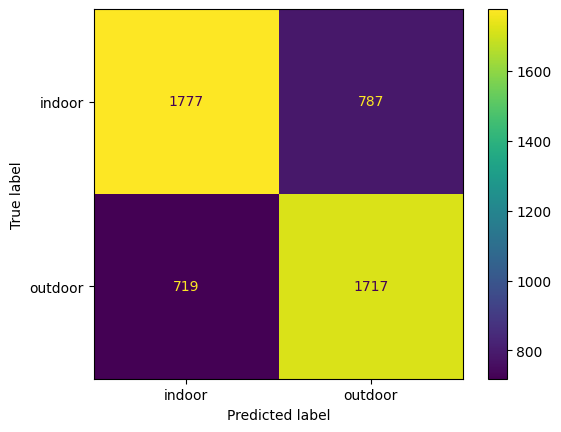

In [47]:
y_pred = clf.predict(X_test_dump)

accuracy = accuracy_score(y_test_dump, y_pred)
precision = precision_score(y_test_dump,y_pred)
recall = recall_score(y_test_dump,y_pred)
f1score = f1_score(y_test_dump,y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1score * 100:.2f}%')
ConfusionMatrixDisplay.from_predictions(y_test_dump,y_pred,display_labels=['indoor','outdoor'])

# Testing model on test image

In [70]:
def load_single_images(image):
    img = Image.open(image)
    img = img.resize((64, 64))
    img = img.convert('L')
    img = np.array(img).flatten()
    img = img/255
    return img

In [71]:
my_img = load_single_images('/content/drive/MyDrive/MuseumTrain/test_image_1.jpg')

In [72]:
clf.predict(my_img.reshape(1,-1))

array([0])

# Model 2

In [48]:
clf2 = DecisionTreeClassifier(
    criterion='gini',
    max_depth=15,
    splitter='best',
    min_samples_split=2,
    min_samples_leaf=30,
    class_weight='balanced',
    max_features='sqrt',
    random_state=42)

clf2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       max_features='sqrt', min_samples_leaf=30,
                       random_state=42)

In [49]:
# Self-training loop (pseudo-labeling)
max_iterations = 10  # Maximum iterations for self-training
confidence_threshold = 0.95  # Minimum confidence for pseudo-labeling

In [50]:
for i in range(max_iterations):

    print(i)
    # Predict pseudo-labels for unlabeled data
    pseudo_labels = clf2.predict(X_unlabeled)
    pseudo_probs = clf2.predict_proba(X_unlabeled).max(axis=1)  # Get confidence scores

    # Select samples with high confidence
    high_confidence_mask = pseudo_probs >= confidence_threshold
    newly_labeled_X = X_unlabeled[high_confidence_mask]
    newly_labeled_y = pseudo_labels[high_confidence_mask]

    # If no new high-confidence labels, stop training
    if len(newly_labeled_X) == 0:
        break

    # Add pseudo-labeled data to training set
    X_train = np.vstack([X_train, newly_labeled_X])
    y_train = np.hstack([y_train, newly_labeled_y])

    # Remove pseudo-labeled samples from unlabeled set
    X_unlabeled = X_unlabeled[~high_confidence_mask]
    y_unlabeled = y_unlabeled[~high_confidence_mask]

    # Retrain Decision Tree with the expanded dataset
    clf2.fit(X_train, y_train)

0
1
2
3
4
5
6
7
8
9


# Evaluation Metrics for Model 2

Accuracy: 70.94%
Precision: 69.92%
Recall: 70.81%
F1 Score: 70.37%


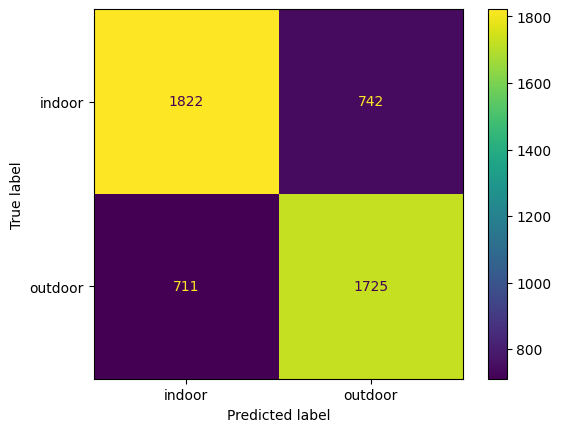

In [51]:
y_pred = clf2.predict(X_test_dump)

accuracy = accuracy_score(y_test_dump, y_pred)
precision = precision_score(y_test_dump,y_pred)
recall = recall_score(y_test_dump,y_pred)
f1score = f1_score(y_test_dump,y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1score * 100:.2f}%')
ConfusionMatrixDisplay.from_predictions(y_test_dump,y_pred,display_labels=['indoor','outdoor'])

# Testing model on test image

In [73]:
clf2.predict(my_img.reshape(1,-1))

array([0])

# Model 3

In [62]:
clf3 = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=9,
    splitter='best',
    min_samples_split=10,
    min_samples_leaf=20,
    class_weight='balanced',
    max_features='log2',
    random_state=42)


clf3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, max_features='log2', min_samples_leaf=20,
                       min_samples_split=10, random_state=42)

In [63]:
# Self-training loop (pseudo-labeling)
max_iterations = 10  # Maximum iterations for self-training
confidence_threshold = 0.95  # Minimum confidence for pseudo-labeling

In [65]:
for i in range(max_iterations):

    print(i)
    # Predict pseudo-labels for unlabeled data
    pseudo_labels = clf3.predict(X_unlabeled)
    pseudo_probs = clf3.predict_proba(X_unlabeled).max(axis=1)  # Get confidence scores

    # Select samples with high confidence
    high_confidence_mask = pseudo_probs >= confidence_threshold
    newly_labeled_X = X_unlabeled[high_confidence_mask]
    newly_labeled_y = pseudo_labels[high_confidence_mask]

    # If no new high-confidence labels, stop training
    if len(newly_labeled_X) == 0:
        break

    # Add pseudo-labeled data to training set
    X_train = np.vstack([X_train, newly_labeled_X])
    y_train = np.hstack([y_train, newly_labeled_y])

    # Remove pseudo-labeled samples from unlabeled set
    X_unlabeled = X_unlabeled[~high_confidence_mask]
    y_unlabeled = y_unlabeled[~high_confidence_mask]

    # Retrain Decision Tree with the expanded dataset
    clf3.fit(X_train, y_train)

0


# Evaluation Metrics for Model 3

Accuracy: 69.84%
Precision: 67.02%
Recall: 75.00%
F1 Score: 70.79%


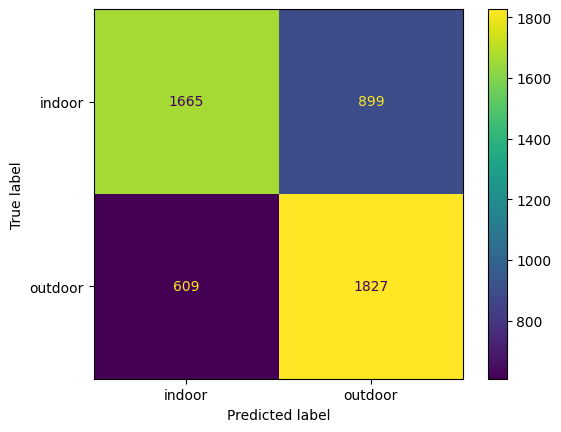

In [66]:
y_pred = clf3.predict(X_test_dump)

accuracy = accuracy_score(y_test_dump, y_pred)
precision = precision_score(y_test_dump,y_pred)
recall = recall_score(y_test_dump,y_pred)
f1score = f1_score(y_test_dump,y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1score * 100:.2f}%')
ConfusionMatrixDisplay.from_predictions(y_test_dump,y_pred,display_labels=['indoor','outdoor'])

# Testing model on test image

In [74]:
clf3.predict(my_img.reshape(1,-1))

array([0])